In [16]:
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import supervision as sv
import numpy as np
from tqdm import tqdm

In [17]:
def load_dataset(segments_folder):
    dataset_information = []   
    for video in os.listdir(segments_folder):
        path = os.path.join(segments_folder, video)
        size = os.path.getsize(path)
        try:
            vi = sv.VideoInfo.from_video_path(path)
            dataset_information.append({
                'width': vi.width, 'height':vi.width, 'fps':vi.fps, 'total_frames':vi.total_frames, 'path':path, 'size':size
            })
        except:
            print(f'Could not open {path}')
    return pd.DataFrame(dataset_information)

df = load_dataset("segments_folder")

In [44]:
df.head()
print(len(df))
import platform
platform.processor()

917


'Intel64 Family 6 Model 186 Stepping 2, GenuineIntel'

In [45]:
import subprocess

def get_cpu_name():
    try:
        result = subprocess.check_output("wmic cpu get name", shell=True)
        cpu_name = result.decode("utf-8").strip().split('\n')[1]
        return cpu_name
    except Exception as e:
        print("Error:", e)
        return None

cpu_name = get_cpu_name()
if cpu_name:
    print("CPU Name:", cpu_name)
else:
    print("CPU name could not be retrieved.")


CPU Name: 13th Gen Intel(R) Core(TM) i5-1340P


In [19]:
model_path = 'yolov8n.pt'
model = YOLO(model_path)  # pretrained YOLOv8n model
if not os.path.isdir('yolov8n_openvino_model/'):
    model.export(format='openvino') 
ov_model = YOLO('yolov8n_openvino_model/', task="detect")


In [35]:
inference_cache = 'inference_cache'
if not os.path.isdir(inference_cache):
    os.mkdir(inference_cache)

def inference(results_folder, model, video):
    if not os.path.isdir(os.path.join(inference_cache, results_folder)):
        os.mkdir(os.path.join(inference_cache, results_folder))
    cached_file = os.path.join(inference_cache,results_folder, os.path.basename(video).replace('.mp4', '.npy'))

    if os.path.exists(cached_file):
        speeds = np.load(cached_file)
        # tqdm.write(f'loaded {cached_file}')
    else:
        results = model.predict(video, classes=[0,1,2,3,5,7], save=True, stream=True, verbose=False)
        speeds = []
        for result in results:
            inference_time = float(result.speed['preprocess'] + result.speed['inference'] + result.speed['postprocess'])
            speeds.append(inference_time)
        np.save(cached_file, speeds)
        # print(f'saved {cached_file}')
    return np.array(speeds)

speeds = {}
for folder in os.listdir(inference_cache):
    speeds[folder] = {}
    with tqdm(total=len(df['path'])) as pbar:
        for video in df['path']:
            speeds[folder][video] = inference(folder, ov_model, video)
            # print(f'{video} mean {speeds[folder][video].mean()}')
            pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████| 917/917 [00:00<00:00, 2541.04it/s]



KeyboardInterrupt



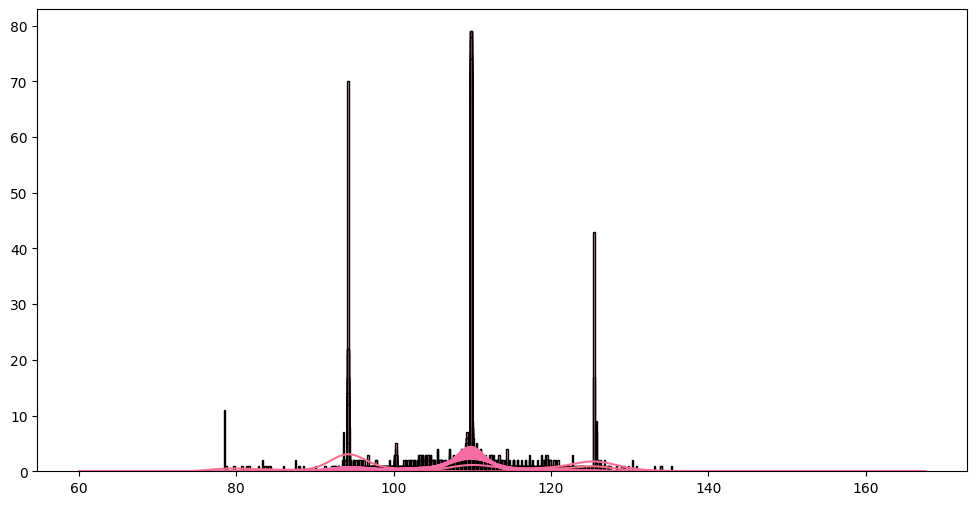

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_compare_distributions(data_dict):
    plt.figure(figsize=(12, 6))

    for folder in data_dict.keys()
        for video_path, inference_speeds in data_dict[folder].items():
            # Plot the distribution using Seaborn for each video
            sns.histplot(inference_speeds, kde=True, label=f'{os.path.basename(folder)}', alpha=0.7)
    
            # Calculate and plot the mean line for each video
            mean_speed = np.mean(inference_speeds)
            plt.axvline(mean_speed, linestyle='dashed', linewidth=2, label=f'{os.path.basename(video_path)} Mean')

    plt.xlabel('Inference Time (ms)')
    plt.ylabel('Frames')
    plt.title('Comparison of Inference Speeds')
    plt.legend()

    plt.show()

plot_compare_distributions(speeds)


yolov8n_desktop
yolov8n_desktop_openvino
yolov8n_laptop
yolov8n_laptop_openvino


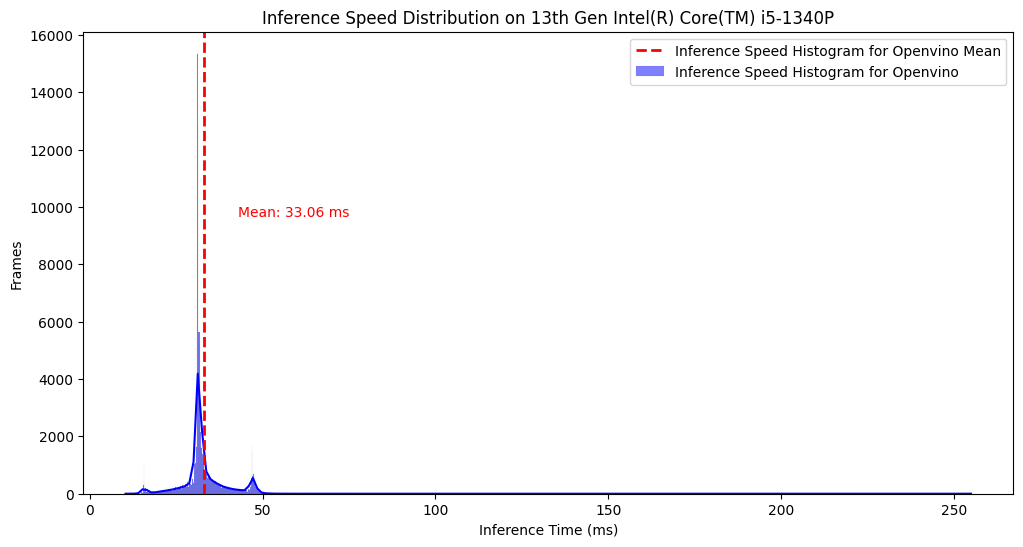

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cpu = cpu_name

def plot_combined_distribution(data_dict, label='Combined Distribution'):
    combined_speeds = []

    for inference_speeds in data_dict.values():
        combined_speeds.extend(inference_speeds)

    plt.figure(figsize=(12, 6))

    # Plot the combined distribution using Seaborn
    sns.histplot(combined_speeds, kde=True, label=label, color='blue')
    mean_speed = np.mean(combined_speeds)
    plt.axvline(mean_speed, linestyle='dashed', linewidth=2, label=f'{label} Mean', color='red')
    plt.text(mean_speed + 10, plt.ylim()[1] * 0.6, f'Mean: {mean_speed:.2f} ms', color='red')


    plt.xlabel('Inference Time (ms)')
    plt.ylabel('Frames')
    plt.title(f'Inference Speed Distribution on {cpu}')
    plt.legend()

    plt.show()

for folder in speeds.keys():
    print(folder)
    # plot_combined_distribution(speeds[folder], label=f'Inference Speed Histogram for {folder}')
plot_combined_distribution(speeds['yolov8n_laptop_openvino'], label=f'Inference Speed Histogram for Openvino')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_compare_distributions(data1, data2, label1='Distribution 1', label2='Distribution 2'):
    plt.figure(figsize=(12, 6))

    # Plot the first distribution using Seaborn (blue)
    sns.histplot(data1, kde=True, color='blue', label=label1)

    # Plot the second distribution using Seaborn (green)
    sns.histplot(data2, kde=True, color='green', label=label2)

    plt.xlabel('Inference Time (ms)')
    plt.ylabel('Frames')
    plt.title('Comparison of Two Distributions')
    plt.legend()

    plt.show()

# Example usage:
# data1 and data2 are the two lists you want to compare
# Replace these with your actual data
data1 = [10, 15, 20, 25, 30, 35, 40]
data2 = [5, 10, 15, 20, 25, 30, 35]

plot_compare_distributions(speeds, data2, label1='Distribution A', label2='Distribution B')


In [69]:
# speeds = [float(i.speed['preprocess']+i.speed['inference']+i.speed['postprocess']) for i in results]

import matplotlib.pyplot as plt
import numpy as np

def plot_distribution(data):
    # Calculate mean and variance of the data
    mean = np.mean(data)
    variance = np.var(data)
    std_deviation = np.sqrt(variance)

    # Create a figure and axis for plotting
    plt.figure(figsize=(10, 6))

    # Plot the histogram of the data
    plt.hist(data, bins=20, density=True, alpha=0.7, color='blue', label='Data Distribution')

    # Plot lines for mean and ±2 standard deviations
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label='Mean')
    plt.axvline(mean + 2 * std_deviation, color='green', linestyle='dotted', linewidth=2, label='+2 Std Dev')
    plt.axvline(mean - 2 * std_deviation, color='green', linestyle='dotted', linewidth=2, label='-2 Std Dev')

    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Data Distribution with Mean and ±2 Std Deviations')
    plt.legend()

    plt.show()

# Example usage:
plot_distribution(speeds)


TypeError: unsupported operand type(s) for /: 'dict' and 'int'

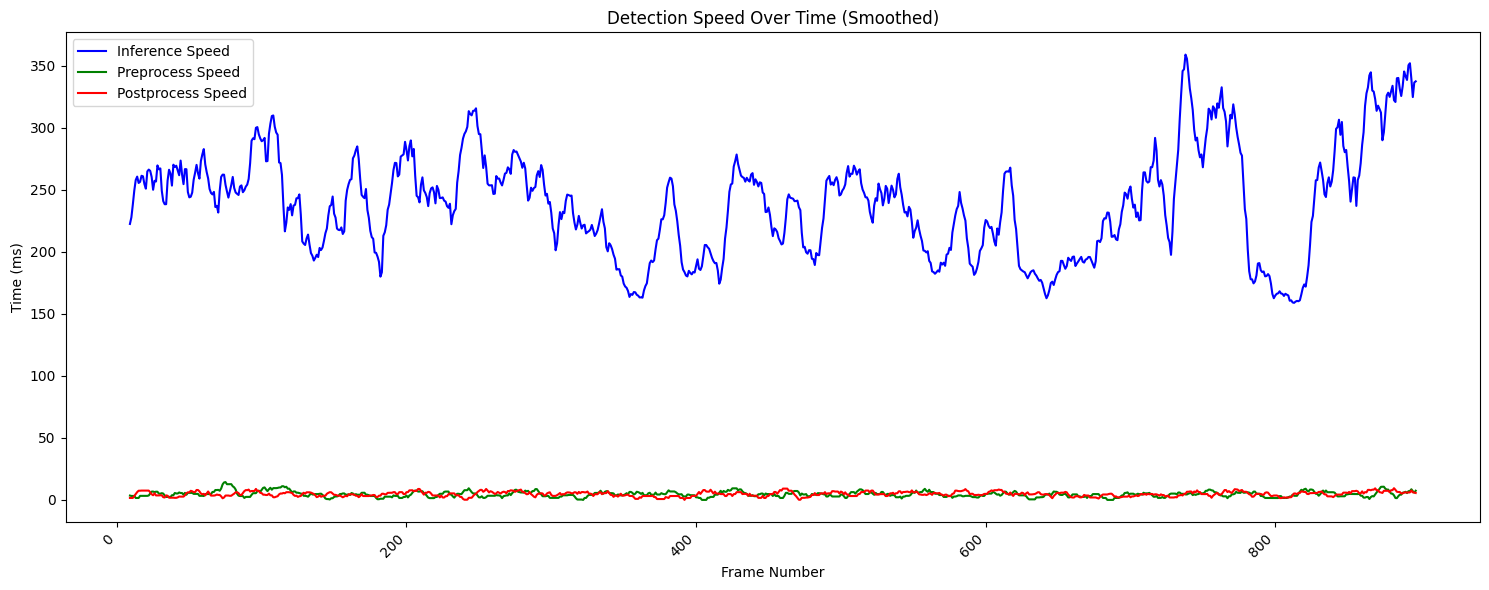

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract speeds from the results objects
preprocess_speeds = [result.speed['preprocess'] for result in results]
inference_speeds = [result.speed['inference'] for result in results]
postprocess_speeds = [result.speed['postprocess'] for result in results]

# Define a smoothing window size (adjust as needed)
smoothing_window = 10

# Calculate rolling averages for each speed category
preprocess_smoothed = [sum(preprocess_speeds[i:i+smoothing_window])/smoothing_window for i in range(len(preprocess_speeds) - smoothing_window + 1)]
inference_smoothed = [sum(inference_speeds[i:i+smoothing_window])/smoothing_window for i in range(len(inference_speeds) - smoothing_window + 1)]
postprocess_smoothed = [sum(postprocess_speeds[i:i+smoothing_window])/smoothing_window for i in range(len(postprocess_speeds) - smoothing_window + 1)]

# Create a count plot of speeds with indices on the x-axis
plt.figure(figsize=(15, 6))  # Adjust the figure size for better visualization

# Plot the smoothed inference speeds in blue
sns.lineplot(x=range(smoothing_window-1, len(inference_smoothed)+smoothing_window-1), y=inference_smoothed, color='blue', label='Inference Speed')

# Plot the smoothed preprocess speeds in green
sns.lineplot(x=range(smoothing_window-1, len(preprocess_smoothed)+smoothing_window-1), y=preprocess_smoothed, color='green', label='Preprocess Speed')

# Plot the smoothed postprocess speeds in red
sns.lineplot(x=range(smoothing_window-1, len(postprocess_smoothed)+smoothing_window-1), y=postprocess_smoothed, color='red', label='Postprocess Speed')

plt.xlabel('Frame Number')
plt.ylabel('Time (ms)')
plt.title('Detection Speed Over Time (Smoothed)')
plt.legend()  # Show legend with labels for each line

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()
